---
# 2. RECOMENDADOR BASADO EN TF-IDF


Ejecutar:
!python -m spacy download en_core_web_sm

<div style="text-align: justify;">

En esta parte vamos a desarrollar un sistema de recomendación literaria basado en TF-IDF.

Desde el comienzo vamos a travajar con un dataset que contiene descripciones limpias de los libros, a partir del cual extraeremos un corpus que representa fielmente el contenido textual de cada obra. Nuestra primera decisión fue utilizar el TF-IDF Vectorizer, ya que este método nos permite transformar las descripciones en vectores numéricos que cuantifican la importancia de cada término en el contexto del documento. Con esto, conseguimos identificar las palabras clave que definen el contenido de cada libro. Este proceso es esencial, pues al reducir el "ruido" de palabras comunes mediante la eliminación de stopwords y la normalización L2, logramos una representación más precisa y robusta del significado de cada texto.

Además, optamos por ajustar parámetros como *max_df*, que nos ayuda a filtrar términos que aparecen en un número excesivo de documentos, eliminando aquellos que, al ser demasiado frecuentes, no aportan información diferenciadora. Esta elección es crucial para evitar que palabras irrelevantes influyan en el análisis y para centrarnos en términos que verdaderamente caracterizan cada libro. También hemos desarrollado una función que extrae las keywords principales de cada documento, lo que nos permite resumir de forma concisa la esencia de cada obra y, a su vez, facilita la visualización del contenido mediante nubes de palabras.

Cuando se trató de construir el recomendador, nuestro objetivo era comparar de manera efectiva las descripciones de los libros. Para ello, transformamos nuevamente las descripciones en vectores y calculamos la similitud del coseno entre ellos. Este método nos permite medir la cercanía semántica entre los libros, y de esta forma, cuando un usuario selecciona un título, el sistema es capaz de identificar y recomendar aquellos libros que son más afines en contenido.

Una de las decisiones más importantes que tomamos fue explorar la inclusión de n-gramas en el vectorizador, estableciendo un rango de 1 a 6. Esta modificación nos permite capturar no solo palabras individuales, sino también secuencias de palabras y patrones lingüísticos que reflejan mejor la narrativa y el estilo característicos de ciertos libros. Por ejemplo, en el caso de obras como la saga de *Harry Potter*, reconocer bi-gramas es fundamental para ofrecer recomendaciones que realmente se alineen con el espíritu del contenido.

Finalmente, hemos asegurado la persistencia del modelo guardando tanto el vectorizador como las matrices resultantes utilizando *pickle*. De este modo, podemos reutilizar el sistema de recomendación sin tener que repetir los costosos cálculos en cada ejecución.

En resumen, nuestro enfoque se fundamenta en extraer y resaltar las características semánticas de cada libro a través de TF-IDF, visualizando y validando la información mediante técnicas como las nubes de palabras, y construyendo un sistema de recomendación que se apoya en la similitud del coseno para ofrecer sugerencias precisas.

</div>

In [ ]:
import pandas as pd


import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = pd.read_csv('datasets/clean_description_english.csv')
dataset

,author,desc,genre,rating,reviews,title,totalratings,idioma,clean_description
0,Helen Fremont,"""To this day, I don't even know what my mother...","Autobiography,Memoir,Nonfiction,World War II,H...",4.00,328,After Long Silence,2898,en,"To this day, I don't even know what my mother'..."
1,Christopher Morley,"Roger Mifflin is part pixie, part sage, part n...","Fiction,Writing,Books About Books,Classics,Hum...",4.03,1214,Parnassus on Wheels,6107,en,"Roger Mifflin is part pixie, part sage, part n..."
2,Robert J. Shiller,As Robert Shillerâ€™s new 2009 preface to his ...,"Economics,Economics,Finance,Business,Nonfictio...",3.98,275,Irrational Exuberance,7019,en,As Robert Shillers new 2009 preface to his pre...
3,Joseph Staten,"This is how it began...,It is the year 2524. H...","Science Fiction,Fiction,Games,Video Games,Spor...",3.98,271,Halo: Contact Harvest,8033,en,"This is how it began...,It is the year 2524. H..."
4,Richard Wiseman,"Is luck just fate, ,or can you change it? ,A g...","Psychology,Nonfiction,Self Help,Science,Self H...",3.82,146,"The Luck Factor: Changing Your Luck, Changing ...",1301,en,"Is luck just fate, ,or can you change it ,A gr..."
...,...,...,...,...,...,...,...,...,...
17447,Robert Jay Lifton,Nazi doctors did more than conduct bizarre exp...,"History,Nonfiction,Psychology,World War II,Hol...",4.10,118,The Nazi Doctors: Medical Killing and the Psyc...,3336,en,Nazi doctors did more than conduct bizarre exp...
17448,Priscilla Glenn,Ever since the one time Andie Weber threw caut...,"New Adult,Romance,Romance,Contemporary Romance...",3.90,450,Emancipating Andie,3974,en,Ever since the one time Andie Weber threw caut...
17449,Amber Kell,"Book one in The Thresl Chronicles Series,When ...","Romance,M M Romance,Science Fiction,Paranormal...",3.90,140,Soldier Mine,1770,en,"Book one in The Thresl Chronicles Series,When ..."
17450,Melissa Lucashenko,A darkly funny novel of romantic love and cult...,"Fiction,Cultural,Australia,Literary Fiction,Co...",3.93,164,Mullumbimby,1257,en,A darkly funny novel of romantic love and cult...


---
## 2.1. Obtención de las KeyWords

Antes de construir el recomendador basado en TF-IDF, vamos a utilizar este método para transformar las descripciones limpias de los libros en un corpus y extraer las keywords principales de cada uno.

- **Creación del corpus y transformación TF-IDF:**  
  Se extraen las descripciones limpias del DataFrame para formar un corpus. Con `TfidfVectorizer` se calcula la matriz TF-IDF, lo que permite medir la importancia de cada término en cada documento.

- **Obtención de nombres de características:**  
  Se extraen los términos (features) que corresponden a las columnas de la matriz TF-IDF.

- **Función `get_top_keywords`:**  
  Para cada documento, se convierte la fila en un array, se ordenan los índices según su valor TF-IDF, y se seleccionan los N términos más altos (ignorando aquellos con valor 0) para identificar las palabras clave.

- **Aplicación y almacenamiento:**  
  La función se aplica a cada documento del corpus y el resultado se almacena en una nueva columna `keywords` del DataFrame, facilitando la identificación del contenido representativo de cada libro.

Respecto de los parámetros de `TFidfVectorizer`, tenemos:

- **norm='l2':**  
  Normaliza los vectores resultantes utilizando la norma L2, lo que significa que la suma de los cuadrados de los componentes de cada vector es 1. Esto ayuda a que la comparación entre documentos sea más consistente.

- **use_idf=True:**  
  Activa la ponderación de IDF (Inverse Document Frequency). Esto permite reducir la influencia de términos muy frecuentes en todo el corpus, haciendo que los términos más únicos para cada documento tengan mayor peso.

- **max_df=50:**  
  Ignora los términos que aparecen en más de 50 documentos. Esto ayuda a eliminar palabras que son demasiado comunes y poco informativas, aunque el valor específico dependerá del tamaño del corpus.

- **smooth_idf=False:**  
  Indica que no se aplicará suavizado a los valores de IDF. Sin suavizado, el cálculo del IDF puede dar valores extremos para términos que aparecen en muy pocos documentos.

- **stop_words='english':**  
  Elimina las palabras vacías (stop words) en inglés, que suelen ser muy comunes y aportan poco valor semántico en el análisis.

In [4]:


# Crear el corpus y transformar a TF-IDF
corpus = dataset['clean_description'].tolist()
tfidf = TfidfVectorizer(norm='l2', use_idf=True, max_df=50, smooth_idf=False, stop_words='english')
tfidf_matrix = tfidf.fit_transform(corpus)

# Obtener los nombres de las características (términos)
feature_names = tfidf.get_feature_names_out()

# Función para obtener los top N términos para cada documento
def get_top_keywords(row, top_n=20):
    # Convertir la fila (documento) a array
    row_array = row.toarray().flatten()
    # Obtener los índices de los términos con mayor TF-IDF
    top_indices = row_array.argsort()[-top_n:][::-1]
    # Seleccionar los términos que tienen un valor mayor a 0 (para omitir términos no presentes)
    keywords = [feature_names[i] for i in top_indices if row_array[i] > 0]
    return keywords

# Aplicar la función a cada documento y almacenar en una lista
keywords_list = [get_top_keywords(tfidf_matrix[i], top_n=20) for i in range(tfidf_matrix.shape[0])]

# Crear una nueva columna en el DataFrame
dataset['keywords'] = keywords_list

pd.set_option('display.max_colwidth', 50)  

# Mostrar las primeras filas para verificar
dataset.head()
dataset.reset_index(drop=True)




,author,desc,genre,rating,reviews,title,totalratings,idioma,clean_description,keywords
0,Helen Fremont,"""To this day, I don't even know what my mother...","Autobiography,Memoir,Nonfiction,World War II,H...",4.00,328,After Long Silence,2898,en,"To this day, I don't even know what my mother'...","[fremont, gulags, unmoved, siberian, damaging,..."
1,Christopher Morley,"Roger Mifflin is part pixie, part sage, part n...","Fiction,Writing,Books About Books,Classics,Hum...",4.03,1214,Parnassus on Wheels,6107,en,"Roger Mifflin is part pixie, part sage, part n...","[mifflin, parnassus, infectiouswith, groaning,..."
2,Robert J. Shiller,As Robert Shillerâ€™s new 2009 preface to his ...,"Economics,Economics,Finance,Business,Nonfictio...",3.98,275,Irrational Exuberance,7019,en,As Robert Shillers new 2009 preface to his pre...,"[exuberance, irrational, bubble, shiller, vola..."
3,Joseph Staten,"This is how it began...,It is the year 2524. H...","Science Fiction,Fiction,Games,Video Games,Spor...",3.98,271,Halo: Contact Harvest,8033,en,"This is how it began...,It is the year 2524. H...","[harvest, trespassed, 2524, humancontrolled, g..."
4,Richard Wiseman,"Is luck just fate, ,or can you change it? ,A g...","Psychology,Nonfiction,Self Help,Science,Self H...",3.82,146,"The Luck Factor: Changing Your Luck, Changing ...",1301,en,"Is luck just fate, ,or can you change it ,A gr...","[wiseman, unlucky, factor, csicop, herfordshir..."
...,...,...,...,...,...,...,...,...,...,...
17447,Robert Jay Lifton,Nazi doctors did more than conduct bizarre exp...,"History,Nonfiction,Psychology,World War II,Hol...",4.10,118,The Nazi Doctors: Medical Killing and the Psyc...,3336,en,Nazi doctors did more than conduct bizarre exp...,"[lifton, supervised, inmates, psychoanalyzes, ..."
17448,Priscilla Glenn,Ever since the one time Andie Weber threw caut...,"New Adult,Romance,Romance,Contemporary Romance...",3.90,450,Emancipating Andie,3974,en,Ever since the one time Andie Weber threw caut...,"[andie, censor, twoday, andies, abrasiveness, ..."
17449,Amber Kell,"Book one in The Thresl Chronicles Series,When ...","Romance,M M Romance,Science Fiction,Paranormal...",3.90,140,Soldier Mine,1770,en,"Book one in The Thresl Chronicles Series,When ...","[kreslan, vohne, thresl, shapeshifting, livesl..."
17450,Melissa Lucashenko,A darkly funny novel of romantic love and cult...,"Fiction,Cultural,Australia,Literary Fiction,Co...",3.93,164,Mullumbimby,1257,en,A darkly funny novel of romantic love and cult...,"[jo, mullumbimby, bundjalung, hinterland, bree..."


In [5]:
## Comprobamos las keywords con la descripción
print("Description:\n",dataset.iloc[17]['clean_description'])
print("Keywords:\n",dataset.iloc[17]['keywords'])

Description:
 Sian Bishop has only ever experienced one moment of recklessness a moment that resulted in her beloved son Rory. Its not that she doesnt love the outcome of that wild night, but since then she has always taken the safer route. So when dependable, devoted Richard suggests a move to the beautiful English countryside, she leaves the hustle and bustle of the city behind, and she throws herself into the picturepostcard cottage garden, her furniture restoration business, and a new life in the country.,Her good intentions are torpedoed on a glorious summers evening with the arrival of Gus Berresford. Onetime explorer and fulltime heartbreaker, Gus is ridiculously exciting, wonderfully glamorous and a completely inappropriate love interest for a single mum. But Gus and Sian have met before,Sian has no use for a fling, she simply mustnt fall in love with the most unlikely suitor ever to cross her path even if he has now crossed her path twice. But who knows what can happen in a su

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

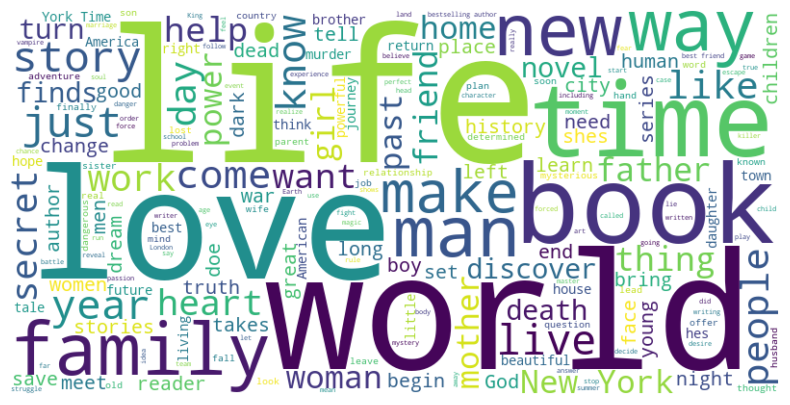

In [7]:
# CONCATENAR TODAS LAS DESCRIPCIONES Y CREAR NUBE DE PALABRAS
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenar todas las descripciones
text = " ".join(dataset["clean_description"])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=tfidf.get_stop_words()).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


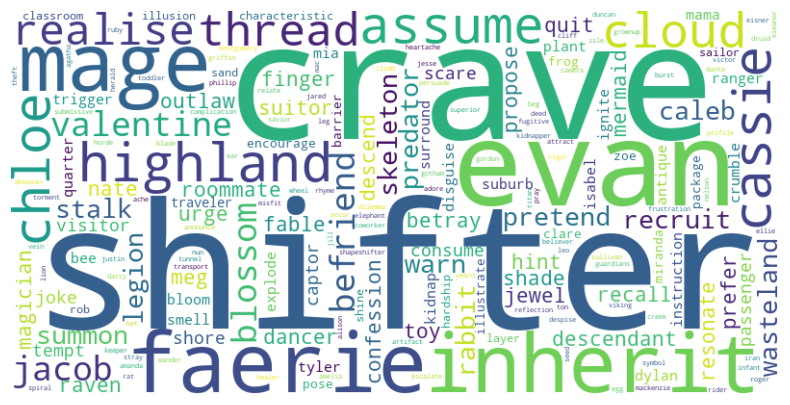

In [8]:
# CONCATENAR LISTAS DE KEYWORDS Y CREAR NUBE DE PALABRAS

# Concatenar las keywords de todos los documentos
all_keywords = " ".join([" ".join(keywords) for keywords in keywords_list])

# Generar la nube de palabras
wordcloud_keywords = WordCloud(width=800, height=400, background_color="white").generate(all_keywords)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_keywords, interpolation="bilinear")
plt.axis("off")
plt.show()


---
## 2.2. Construcción del Recomendador basado en TF-IDF

Ahora vamos a configurar y aplicar el vectorizador TF-IDF sobre las descripciones limpias de los libros para extraer características relevantes que posteriormente se usarán en el sistema de recomendación.

1. **Configuración del vectorizador TF-IDF:**
   - **analyzer="word":**  
     Se define que la tokenización se realizará a nivel de palabras.
   - **stop_words='english':**  
     Se eliminan las palabras vacías en inglés, ya que suelen tener poco valor semántico para diferenciar documentos.
   - **norm='l2':**  
     Se normalizan los vectores resultantes utilizando la norma L2, lo que ayuda a mantener la consistencia en la comparación entre documentos.
   - **use_idf=True:**  
     Se utiliza la ponderación IDF (Inverse Document Frequency) para dar más peso a los términos que son poco frecuentes en el corpus.
   - **max_df=30:**  
     Se filtran los términos que aparecen en más de 30 documentos, lo que evita que palabras demasiado comunes influyan en el análisis.
   - **smooth_idf=False:**  
     No se aplica suavizado en el cálculo del IDF, lo que puede dar valores más extremos en función de la distribución de los términos.

2. **Aplicación del vectorizador:**
   - La función `.fit()` se aplica a la columna `clean_description` del DataFrame `df_tfidf`, lo que permite que el vectorizador aprenda el vocabulario y la distribución de términos en el corpus.
   - Luego, con `.transform()`, se convierte cada descripción en un vector numérico (TF-IDF), generando la matriz `tfidf_matrix` que representa las características de cada documento.



In [10]:
df_tfidf = dataset.copy()
df_tfidf["keywords"] = df_tfidf["keywords"].apply(lambda x: " ".join(x))

In [11]:
# Aplicar TF-IDF Vectorizer
tf = TfidfVectorizer(
    analyzer="word",
    stop_words='english',
    norm='l2',
    use_idf=True,
    max_df=30,
    smooth_idf=False
).fit(df_tfidf["clean_description"])

# Transformar los datos
tfidf_matrix = tf.transform(df_tfidf["clean_description"])

La línea `tf.vocabulary_` devuelve el vocabulario aprendido por el vectorizador, es decir, un diccionario donde cada término se asocia con un índice correspondiente. 

In [12]:
tf.vocabulary_

{'fremont': 29891,
 'jewishholocaust': 40642,
 'recounting': 63092,
 'resonance': 64236,
 'pieced': 58502,
 'siberian': 69756,
 'gulags': 33368,
 'foolish': 29105,
 'unmoved': 80500,
 'damaging': 19118,
 'mifflin': 49696,
 'pixie': 58796,
 'sage': 66344,
 'wagon': 82519,
 'parnassus': 56936,
 '1915': 634,
 'itinerant': 39912,
 'infectiouswith': 38587,
 'spinster': 72165,
 'disgruntled': 21745,
 'roaring': 65155,
 'yarn': 85408,
 'spiced': 72095,
 'roadside': 65136,
 'brawls': 10854,
 'groaning': 33030,
 'boards': 9834,
 'yankee': 85391,
 'cookery': 17179,
 'storynot': 73434,
 '1900s': 608,
 'shillers': 69314,
 'prescient': 60246,
 'behavioral': 8202,
 'volatility': 82327,
 'asserts': 5860,
 'irrational': 39639,
 'exuberance': 26780,
 'magnitude': 46871,
 'investors': 39479,
 'crawl': 18025,
 'wreckage': 85056,
 'heedless': 35049,
 'shrewd': 69654,
 'sober': 71241,
 'shiller': 69313,
 'marshals': 47867,
 'evoked': 26124,
 'greenspans': 32825,
 'alternately': 3679,
 'declining': 19974,
 

In [13]:
#Analizamos qué tipo de elemento es tfidf_matrix
tfidf_matrix

<17452x86217 sparse matrix of type '<class 'numpy.float64'>'
	with 287963 stored elements in Compressed Sparse Row format>

In [14]:
#Comprobamos que las filas son sparse
tfidf_matrix.toarray()[0:1, :]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

#Calculamos la matriz de similaridad del coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [16]:
#Para analizarla, calculamos la submatriz 4x4
cosine_sim[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Antes de pasar a la función, cabe señalar que primero vamos a extraer la columna de títulos y crear una Serie que mapea cada título a su índice correspondiente, lo que va a facilitar la localización de cada libro en el DataFrame.

La función `keywords_recommendations(title)` opera de la siguiente manera:

- **Obtención del índice:**  
  Se utiliza el título proporcionado para recuperar el índice del libro en el DataFrame a través de la Serie `indices`.

- **Cálculo de similitud:**  
  Se extraen los puntajes de similitud (usando la matriz `cosine_sim`) del libro seleccionado con respecto a todos los demás libros. Estas  puntuaciones se enumeran para poder asociarlos con sus respectivos índices.

- **Ordenación y selección:**  
  Las puntuaciones se ordenan de mayor a menor y se descarta el primer elemento, que corresponde al propio libro. Luego, se seleccionan los 20 libros más similares.

- **Recuperación de títulos:**  
  Finalmente, se extraen los títulos correspondientes a los índices seleccionados y se devuelven como recomendaciones.


In [17]:
titles = df_tfidf["title"]
indices = pd.Series(df_tfidf.index, index=df_tfidf["title"])


def keywords_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Probamos nuestro recomendador:

In [18]:
keywords_recommendations("Harry Potter and the Methods of Rationality").head(5)

6933                          Princess of the Silver Woods
15344                              His Grandfather's Watch
14631                                              Fangirl
2752                                       Hugs from Pearl
934      Descartes' Error: Emotion, Reason and the Huma...
Name: title, dtype: object

Para mejorar la precisión de las recomendaciones y asegurarnos de que los libros sugeridos estén estrechamente relacionados con "Harry Potter", hemos decidido explorar el parámetro `ngram_range`. Este parámetro se ajusta a `(1, 6)`, lo que permite capturar secuencias de palabras que van desde un solo término (unigram) hasta grupos de seis palabras (6-gram).

La inclusión de n-gramas amplía el contexto de las descripciones, permitiendo identificar frases y combinaciones de palabras características de la narrativa y estilo de "Harry Potter". De esta forma, el modelo no solo analiza palabras individuales, sino también patrones y expresiones que resultan representativos de la saga.

In [19]:
# Aplicar TF-IDF Vectorizer
tf_II = TfidfVectorizer(
    analyzer="word",
    stop_words='english',
    norm='l2',
    use_idf=True,
    max_df=30,
    smooth_idf=False,
    ngram_range=(1, 6)
).fit(df_tfidf["clean_description"])

# Transformar los datos
tfidf_matrix_II = tf_II.transform(df_tfidf["clean_description"])

In [20]:
tf_II.vocabulary_

{'fremont': 2332464,
 'jewishholocaust': 3154170,
 'recounting': 4931027,
 'resonance': 5016107,
 'pieced': 4539733,
 'siberian': 5450058,
 'gulags': 2597465,
 'foolish': 2270013,
 'unmoved': 6334563,
 'damaging': 1355484,
 'day don': 1408098,
 'know mother': 3304392,
 'mother real': 4037284,
 'real helen': 4890508,
 'helen fremont': 2717959,
 'fremont raised': 2332470,
 'raised roman': 4846996,
 'roman catholic': 5120326,
 'catholic wasn': 874257,
 'wasn adult': 6510234,
 'adult practicing': 113388,
 'practicing law': 4667187,
 'law boston': 3377326,
 'boston discovered': 674224,
 'discovered parents': 1620060,
 'parents jewishholocaust': 4409229,
 'jewishholocaust survivors': 3154171,
 'survivors living': 5856158,
 'living invented': 3582552,
 'invented lives': 3075003,
 'lives names': 3575646,
 'names powerful': 4107654,
 'powerful memoir': 4657440,
 'memoir helen': 3896383,
 'fremont delves': 2332465,
 'delves secrets': 1498984,
 'secrets held': 5294120,
 'held family': 2717137,
 '

In [21]:
tfidf_matrix_II

<17452x6832043 sparse matrix of type '<class 'numpy.float64'>'
	with 7352029 stored elements in Compressed Sparse Row format>

In [22]:

#Calculamos la matriz de similaridad del coseno
cosine_sim_II = cosine_similarity(tfidf_matrix_II, tfidf_matrix_II)

In [23]:
def keywords_recommendations_II(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_II[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [24]:
keywords_recommendations_II("Harry Potter and the Methods of Rationality").head(5)

12083                      Looking for God in Harry Potter
6933                          Princess of the Silver Woods
6041     The Sorcerer's Companion: A Guide to the Magic...
1965     Harry Potter Page to Screen: The Complete Film...
13970              Harry Potter and the Chamber of Secrets
Name: title, dtype: object

Al aplicar el nuevo TF-IDF con `ngram_range=(1,6)`, hemos obtenido resultados más precisos. Ahora, las recomendaciones están mejor enfocadas en libros relacionados con "Harry Potter". Los títulos sugeridos, como "Harry Potter and the Chamber of Secrets" y "Harry Potter Page to Screen: The Complete Film...", evidencian que el modelo capta mejor el contexto y las frases características de la saga. Este ajuste demuestra una mejora en la extracción de características relevantes, lo que se traduce en recomendaciones de mayor calidad y afinidad temática.

Guardamos los resultados

In [26]:
import pickle

# Guardar el vectorizador
with open('modelos/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tf_II, file)

# Guardar la matriz TF-IDF
with open('modelos/tfidf_matrix.pkl', 'wb') as file:
    pickle.dump(tfidf_matrix_II, file)

# Guardar la matriz de similitud del coseno
with open('modelos/cosine_sim_II.pkl', 'wb') as file:
    pickle.dump(cosine_sim_II, file)

--- 
## 2.3. Estudio del error

En el campo de los sistemas de recomendación, la evaluación del error es un desafío particular, ya que no se cuenta con métricas directas y universales como en problemas de clasificación. Durante el desarrollo del proyecto, hemos estudiado diversas técnicas de evaluación para recomendadores, y a continuación, presentamos un resumen de estas metodologías.

### Evaluación Offline

En un primer enfoque, se pueden utilizar evaluaciones offline, que consisten en dividir el dataset en conjuntos de entrenamiento y prueba. Aunque esta metodología es común en tareas de clasificación, en sistemas de recomendación se adaptan métricas específicas, tales como:

- **Hit Rate y Precision@K:** Miden la frecuencia con la que los ítems recomendados incluyen aquellos que el usuario ha consumido o valorado positivamente.
- **NDCG (Normalized Discounted Cumulative Gain):** Valora la posición de los ítems relevantes en la lista de recomendaciones, penalizando aquellos que aparecen en posiciones inferiores.
- **MAP (Mean Average Precision):** Proporciona una medida global de la precisión, considerando la relevancia de las recomendaciones en distintos niveles.

Estas métricas ofrecen una valoración cuantitativa de la calidad del sistema sin requerir pruebas en un entorno en vivo.

### A/B Testing

En este método, se presentan diferentes versiones del recomendador a distintos grupos de usuarios y se comparan sus rendimientos basados en métricas reales, como:

- **Tasa de Conversión:** Proporción de usuarios que realizan una acción deseada, por ejemplo, seleccionar un libro recomendado.
- **Tiempo de Interacción:** Duración de la sesión o tiempo dedicado a explorar las recomendaciones.
- **Feedback Directo:** Valoraciones o comentarios proporcionados por los usuarios sobre la utilidad de las recomendaciones.

El A/B testing permite validar en condiciones reales cómo interactúan los usuarios con el sistema y ajustar, en consecuencia, parámetros o estrategias de recomendación.

### Feedback en Tiempo Real y Modelos de Reinforcement Learning

Otra línea de investigación que hemos estudiado es el uso del feedback en tiempo real, el cual busca adaptar las recomendaciones en función de la interacción inmediata del usuario. Este enfoque puede incluir técnicas de **reinforcement learning**, donde el sistema aprende a optimizar sus sugerencias basándose en recompensas derivadas de comportamientos como clicks o conversiones. Esta técnica muestra un potencial elevado para mejorar la personalización y actualmente se encuentra en una fase exploratoria para muchos escenarios de recomendación.

### Consideraciones Finales

Si bien hemos investigado estas técnicas de evaluación para sistemas de recomendación, un análisis exhaustivo del error en este contexto resulta complejo y se escapa del alcance de este trabajo. Por ello, hemos decidido enfocar nuestro estudio del error en el clasificador basado en LSTM, donde contamos con métricas claras como precisión y pérdida.

En resumen, hemos estudiado metodologías como la evaluación offline, A/B testing y el feedback en tiempo real para mejorar la calidad de los recomendadores. Sin embargo, dado que estas técnicas requieren un enfoque más profundo y específico, las consideramos líneas de investigación futuras para perfeccionar nuestros sistemas de recomendación.